
# Bank Term Deposit Subscription Prediction

This project aims to predict whether a client will **subscribe to a long-term bank deposit** based on demographic, financial, and marketing data.

---

## Introduction & Objectives
The goal of this notebook is to apply **machine learning techniques** to predict bank term deposit subscriptions.  
We will explore the dataset, preprocess it, train models, and evaluate their performance.

---

## 1. Data Loading & Overview
We start by importing the dataset and examining its structure to understand the data fields and their distributions.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from scipy.stats import skew
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [3]:
data_path = "bank-additional-full.csv"
data = pd.read_csv(data_path, sep=';')
print(data.isna().sum()) # Check for missing values
data.head()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no



---

## 2. Exploratory Data Analysis & Data Preprocessing
In this section, we explore the dataset to identify patterns, correlations, and potential data quality issues.  
We’ll generate summary statistics and visualizations to better understand the features.

Taking into account the findings of the exploratory data analysis we prepare the data for modeling by handling missing values, encoding categorical variables, scaling features, and splitting into training and test sets.


In [4]:
# --- Drop duration as it is a leakage feature (previous to contact there is no way of knowing how long the call will be) ---
if 'duration' in data.columns:
    data = data.drop(columns=['duration'])
    print("Removed 'duration' (leakage feature).")

# --- Cap extreme values in 'campaign' ---
cap_value = 20
num_capped = (data['campaign'] > cap_value).sum()
data['campaign'] = np.where(data['campaign'] > cap_value, cap_value, data['campaign'])
print(f"Capped {num_capped} values in 'campaign' above {cap_value}.")

# --- Handle special code in 'pdays' (999 means not previously contacted) ---
if 'pdays' in data.columns:
    num_999 = (data['pdays'] == 999).sum()
    percent_999 = num_999 / len(data) * 100
    print(f"{percent_999:.2f}% dels valors de 'pdays' són 999")
    data = data.drop(columns=['pdays'])
    print("Removed 'pdays' (leakage feature).")


# --- Remove unrealistic ages (>100 years) ---
old_count = (data['age'] > 100).sum()
data = data[data['age'] <= 100]
print(f"Removed {old_count} rows with 'age' > 100.")

# --- Display summary after cleaning ---
print("\n✅ Dataset cleaned successfully!")
print("Shape after cleaning:", data.shape)

Removed 'duration' (leakage feature).
Capped 157 values in 'campaign' above 20.
96.32% dels valors de 'pdays' són 999
Removed 'pdays' (leakage feature).
Removed 0 rows with 'age' > 100.

✅ Dataset cleaned successfully!
Shape after cleaning: (41188, 19)


Skewness of numerical variables:
 age               0.784668
campaign          3.475178
previous          3.831903
emp.var.rate     -0.724069
cons.price.idx   -0.230879
cons.conf.idx     0.303169
euribor3m        -0.709162
nr.employed      -1.044224
dtype: float64


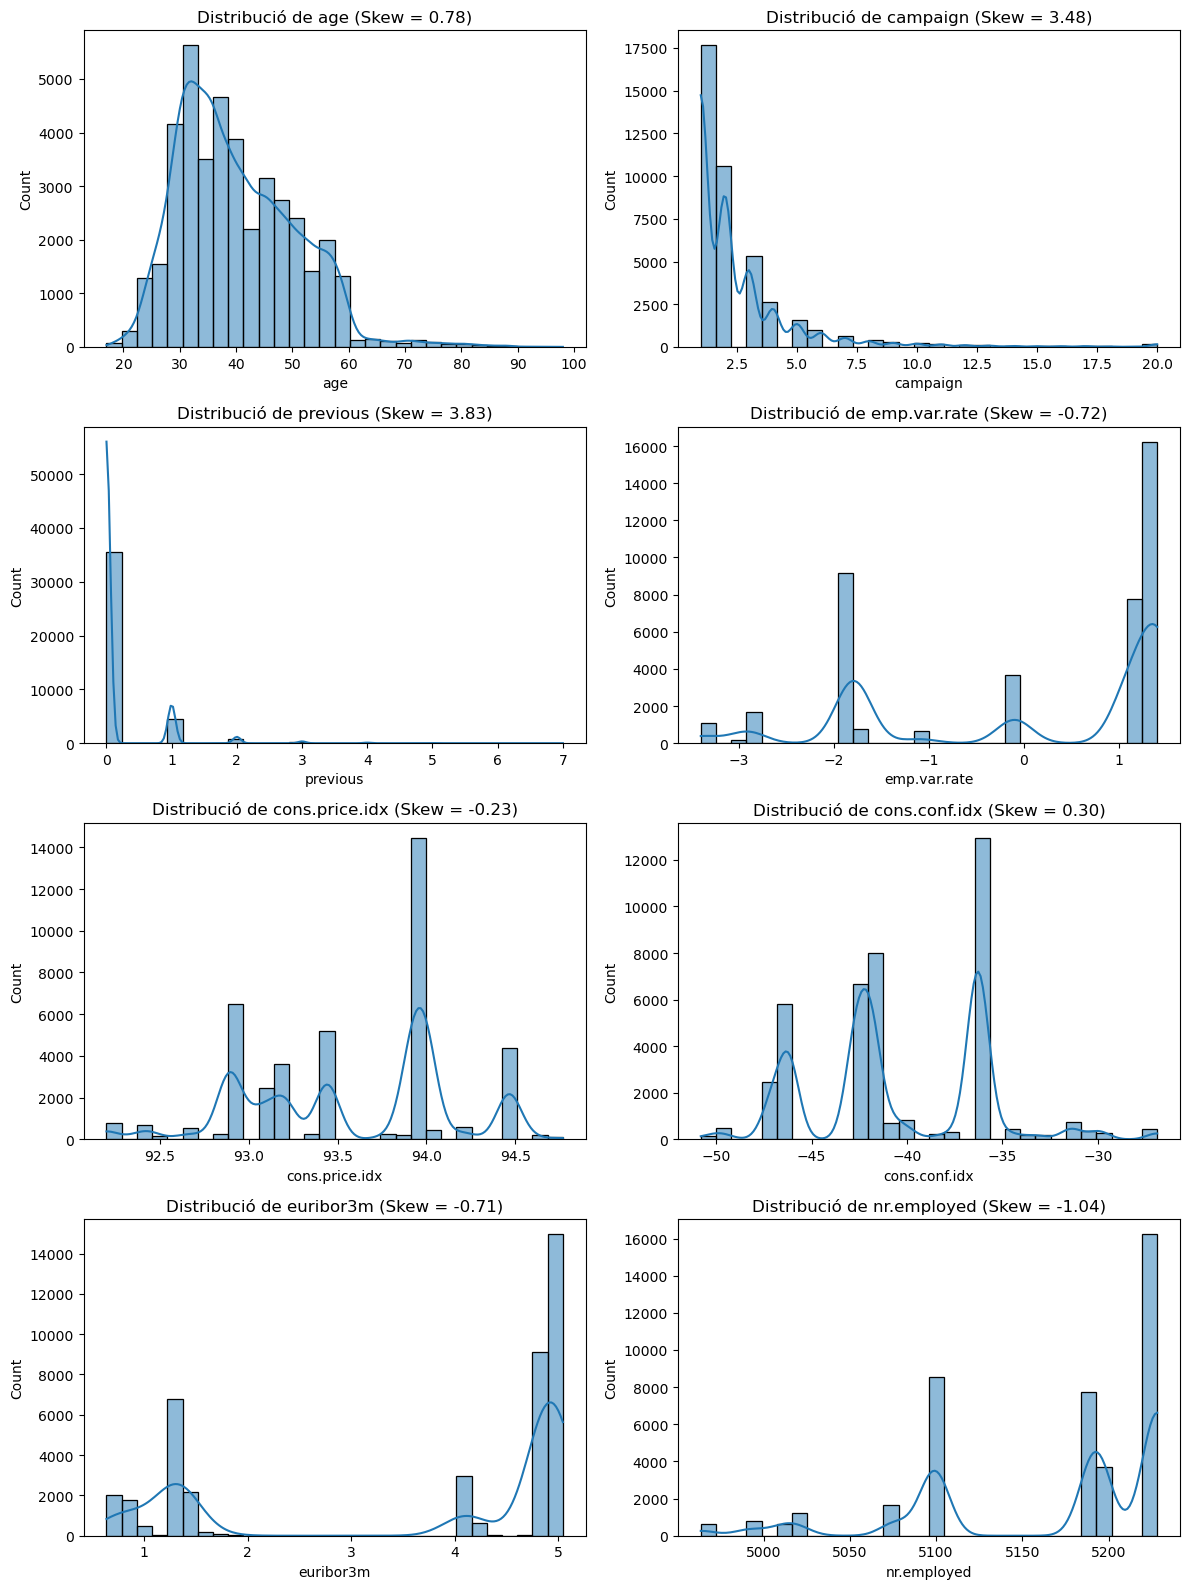

In [5]:
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
skewness = data[num_cols].apply(lambda x: skew(x.dropna()))
print("Skewness of numerical variables:\n", skewness)


cols_per_row = 2
n_rows = math.ceil(len(num_cols) / cols_per_row)
fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(12, n_rows * 4))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.histplot(data[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"Distribució de {col} (Skew = {skewness[col]:.2f})")

plt.tight_layout()
plt.show()

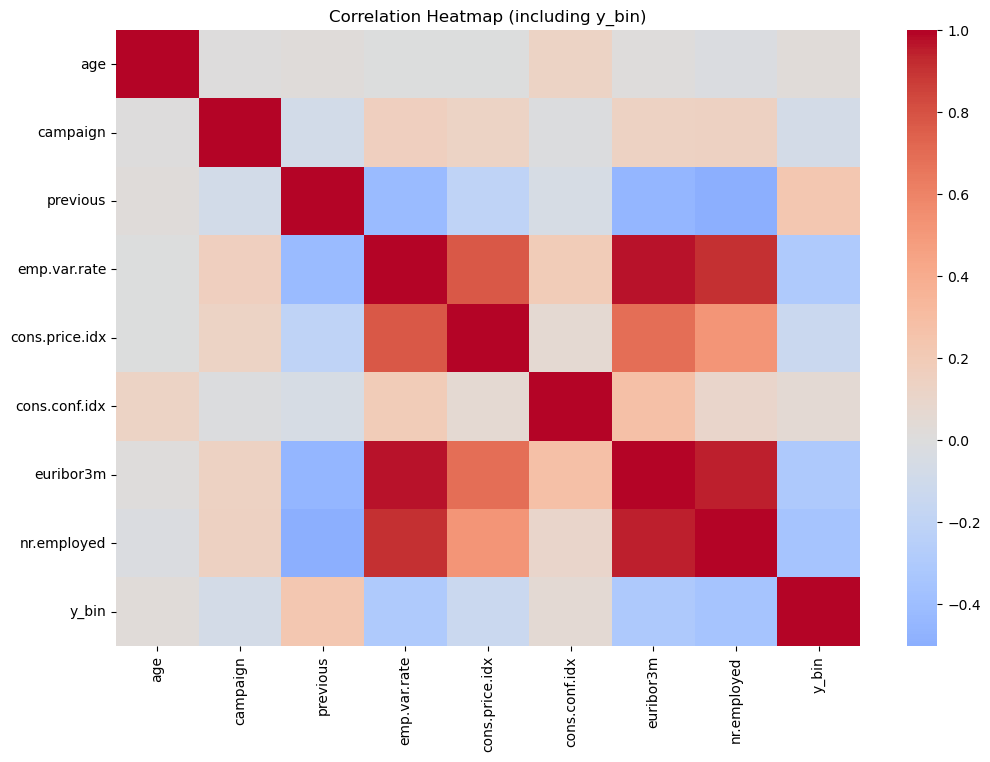

In [6]:
data_corr = data.copy()
if 'y' in data_corr.columns:
    data_corr['y_bin'] = data_corr['y'].map({'yes': 1, 'no': 0})
else:
    print("⚠️ No hi ha columna 'y' al DataFrame original")
    
corr_matrix = data_corr.select_dtypes(include=['int64','float64']).corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (including y_bin)")
plt.show()

# Correlations with the predicted variable:
#if 'y_bin' in corr_matrix.columns:
#    target_corr = corr_matrix['y_bin'].sort_values(key=abs, ascending=False)
#    print("\nCorrelacions amb la variable objectiu 'y':\n", target_corr)

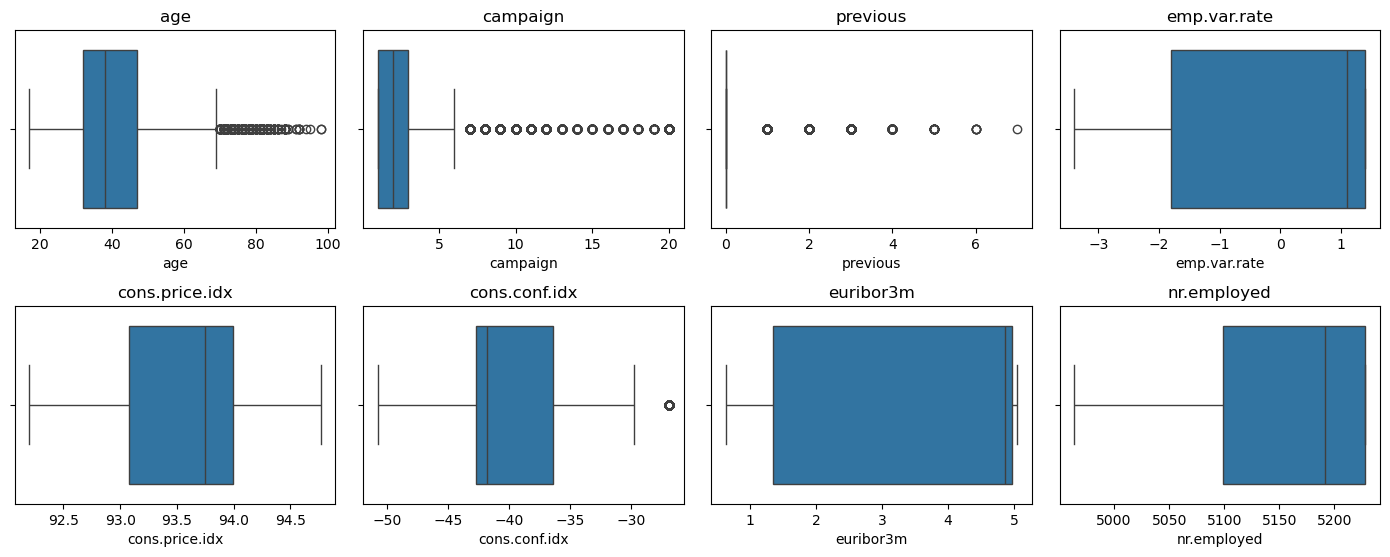

In [7]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
# --- IQR Method (Interquartile Range) ---
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


# --- Z-Score Method ---
from scipy import stats

z_scores = np.abs(stats.zscore(data[numeric_cols]))
threshold = 3
outlier_rows = np.where(z_scores > threshold)

# --- Boxplot Visualizations ---
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

Top more important categorical features (chi2):


,Feature,Chi2,p_value
52,poutcome_success,3982.548056,0.000000e+00
40,month_mar,842.916583,2.520714e-185
43,month_oct,763.644573,4.331272e-168
44,month_sep,645.541017,2.083806e-142
34,contact_telephone,547.958309,3.500598e-121
8,job_student,355.864620,2.239058e-79
5,job_retired,335.662863,5.616159e-75
41,month_may,321.423320,7.093710e-72
25,default_unknown,321.320431,7.469382e-72
33,contact_cellular,315.310771,1.521738e-70


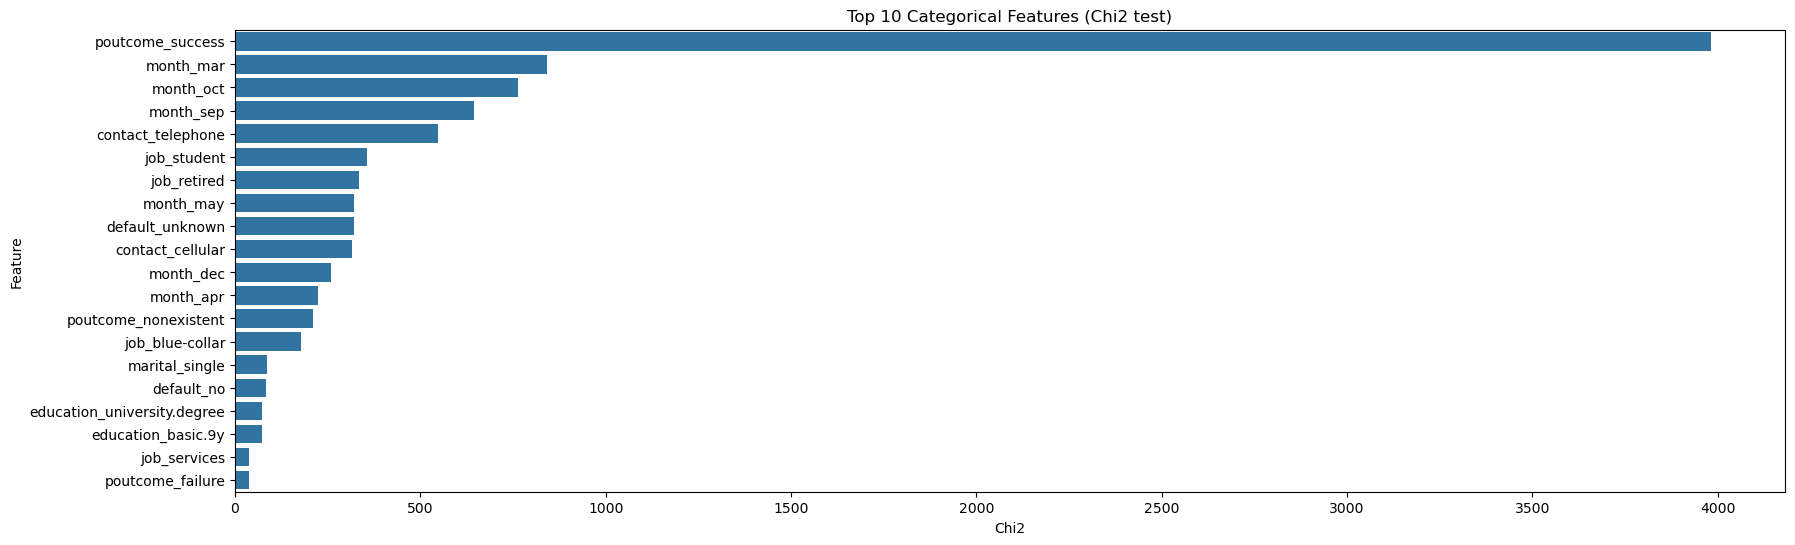

In [8]:
# Separate features and target
X = data.drop('y', axis=1)
y = data['y'].map({'yes': 1, 'no': 0})

encoder = OneHotEncoder(handle_unknown='ignore')
X_cat = encoder.fit_transform(X.select_dtypes(include='object'))

chi_scores, p_values = chi2(X_cat, y)

feature_names = encoder.get_feature_names_out(X.select_dtypes(include='object').columns)
chi2_results = pd.DataFrame({'Feature': feature_names, 'Chi2': chi_scores, 'p_value': p_values})
chi2_results = chi2_results.sort_values('Chi2', ascending=False)

print("Top more important categorical features (chi2):")
display(chi2_results.head(20))

plt.figure(figsize=(20,6))
sns.barplot(x="Chi2", y="Feature", data=chi2_results.head(20))
plt.title("Top 10 Categorical Features (Chi2 test)")
plt.show()

In [9]:
# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        # One-hot encode categorical features, keeping "unknown" as a valid category
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        # Standardize numerical features
        ('num', StandardScaler(), numerical_features)
    ]
)

# Apply preprocessing to the dataset
X_preprocessed = preprocessor.fit_transform(X)

print("Shape before encoding:", X.shape)
print("Shape after encoding:", X_preprocessed.shape)

Shape before encoding: (41188, 18)
Shape after encoding: (41188, 61)


In [10]:
encoded_cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

X_preprocessed_df = pd.DataFrame(
    X_preprocessed.toarray() if hasattr(X_preprocessed, "toarray") else X_preprocessed,
    columns=list(encoded_cat_features) + list(numerical_features)
)

# Add target variable back
X_preprocessed_df['y'] = y.values

# Save the final preprocessed dataset to CSV
X_preprocessed_df.to_csv('bank_preprocessed.csv', index=False)


---

## 3. Model Training & Model Evaluation
We train multiple machine learning models (e.g., Decision Tree, Random Forest) to predict whether a client will subscribe to the term deposit.

We evaluate the performance of the trained models using metrics such as accuracy, precision, recall, F1-score, and the confusion matrix, but it must be noted that we consider recall to be the most relevant statistic given the goal of the prediction.



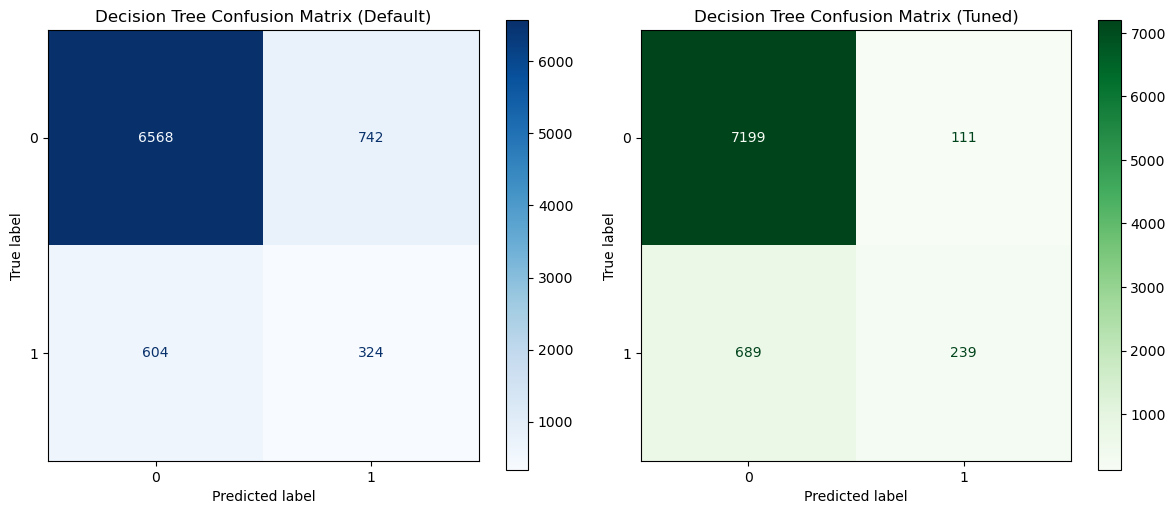

10-Fold Cross-Validation Results (Decision Tree)


,Max Depth,Min Samples Split,Min Samples Leaf,Criterion,Mean CV Accuracy,Mean CV Precision,Mean CV Recall,Mean CV F1
26,5,10,5,gini,0.900516,0.882920,0.900516,0.880578
25,5,5,5,gini,0.900516,0.882920,0.900516,0.880578
24,5,2,5,gini,0.900516,0.882920,0.900516,0.880578
27,5,20,5,gini,0.900455,0.882810,0.900455,0.880479
22,5,10,2,gini,0.900364,0.882666,0.900364,0.880412
20,5,2,2,gini,0.900364,0.882666,0.900364,0.880412
21,5,5,2,gini,0.900364,0.882666,0.900364,0.880412
16,5,2,1,gini,0.900334,0.882620,0.900334,0.880388
17,5,5,1,gini,0.900334,0.882620,0.900334,0.880388
23,5,20,2,gini,0.900334,0.882620,0.900334,0.880388


In [11]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, test_size=0.2, random_state=42, stratify=y
)

# Default Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Grid Search
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid={
        'max_depth': [3, 5, 10, 15, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    cv=10,
    scoring=scoring,
    refit='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_dt = grid.best_estimator_

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test, cmap="Blues", ax=axes[0])
axes[0].set_title("Decision Tree Confusion Matrix (Default)")
ConfusionMatrixDisplay.from_estimator(best_dt, X_test, y_test, cmap="Greens", ax=axes[1])
axes[1].set_title("Decision Tree Confusion Matrix (Tuned)")
plt.tight_layout()
plt.show()

# Convert results to DataFrame and rename columns
results_df = pd.DataFrame(grid.cv_results_)
results_summary = results_df[[
    'param_max_depth',
    'param_min_samples_split',
    'param_min_samples_leaf',
    'param_criterion',
    'mean_test_accuracy',
    'mean_test_precision',
    'mean_test_recall',
    'mean_test_f1'
]].rename(columns={
    'param_max_depth': 'Max Depth',
    'param_min_samples_split': 'Min Samples Split',
    'param_min_samples_leaf': 'Min Samples Leaf',
    'param_criterion': 'Criterion',
    'mean_test_accuracy': 'Mean CV Accuracy',
    'mean_test_precision': 'Mean CV Precision',
    'mean_test_recall': 'Mean CV Recall',
    'mean_test_f1': 'Mean CV F1'
})

results_summary = results_summary.sort_values(by='Mean CV Accuracy', ascending=False)
print("10-Fold Cross-Validation Results (Decision Tree)")
display(results_summary.head(10))

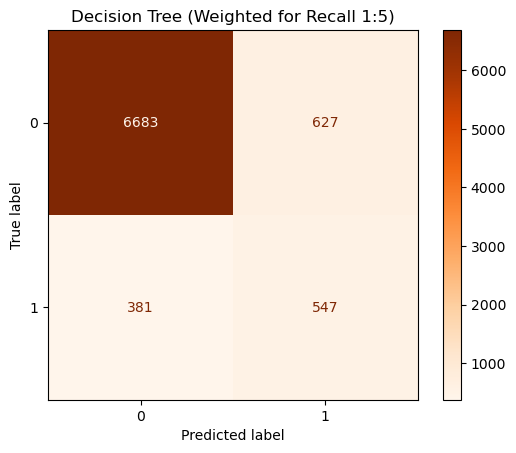


Weighted Decision Tree — Hyperparameters and Performance


,Hyperparameter,Value
0,max_depth,5
1,min_samples_split,2
2,min_samples_leaf,5
3,criterion,gini
4,class_weight,"{0:1, 1:5}"
5,Accuracy (test set),0.8776
6,Precision (positive class),0.4659
7,Recall (positive class),0.5894
8,F1-score (positive class),0.5205


In [12]:
best_params = grid.best_params_

dt_weighted = DecisionTreeClassifier(
    random_state=42,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    class_weight={0:1, 1:5}  # 🔸 increase weight of the minority/positive class
)

# Train the weighted model
dt_weighted.fit(X_train, y_train)
y_pred_weighted = dt_weighted.predict(X_test)

# Compute metrics
acc = accuracy_score(y_test, y_pred_weighted)
prec = precision_score(y_test, y_pred_weighted)
rec = recall_score(y_test, y_pred_weighted)
f1 = f1_score(y_test, y_pred_weighted)

# Confusion matrix & results
ConfusionMatrixDisplay.from_estimator(dt_weighted, X_test, y_test, cmap="Oranges")
plt.title("Decision Tree (Weighted for Recall 1:5)")
plt.show()

results_table = pd.DataFrame({
    'Hyperparameter': [
        'max_depth', 
        'min_samples_split', 
        'min_samples_leaf', 
        'criterion', 
        'class_weight', 
        'Accuracy (test set)', 
        'Precision (positive class)', 
        'Recall (positive class)', 
        'F1-score (positive class)'
    ],
    'Value': [
        best_params['max_depth'],
        best_params['min_samples_split'],
        best_params['min_samples_leaf'],
        best_params['criterion'],
        '{0:1, 1:5}',
        f"{acc:.4f}",
        f"{prec:.4f}",
        f"{rec:.4f}",
        f"{f1:.4f}"
    ]
})
print("\nWeighted Decision Tree — Hyperparameters and Performance")
display(results_table)


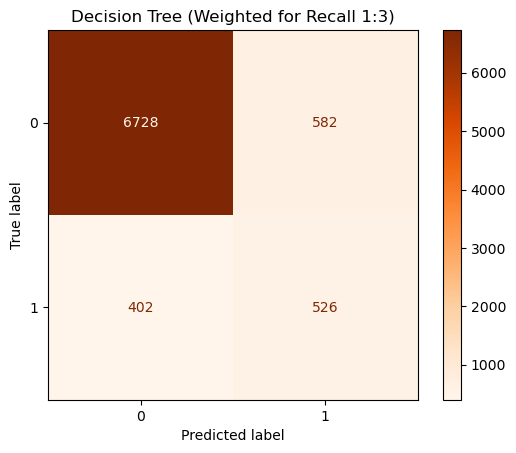


Weighted Decision Tree — Hyperparameters and Performance


,Hyperparameter,Value
0,max_depth,5
1,min_samples_split,2
2,min_samples_leaf,5
3,criterion,gini
4,class_weight,"{0:1, 1:3}"
5,Accuracy (test set),0.8806
6,Precision (positive class),0.4747
7,Recall (positive class),0.5668
8,F1-score (positive class),0.5167


In [13]:
best_params = grid.best_params_

dt_weighted = DecisionTreeClassifier(
    random_state=42,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    class_weight={0:1, 1:3}
)

dt_weighted.fit(X_train, y_train)
y_pred_weighted = dt_weighted.predict(X_test)

acc = accuracy_score(y_test, y_pred_weighted)
prec = precision_score(y_test, y_pred_weighted)
rec = recall_score(y_test, y_pred_weighted)
f1 = f1_score(y_test, y_pred_weighted)

results_table = pd.DataFrame({
    'Hyperparameter': [
        'max_depth', 
        'min_samples_split', 
        'min_samples_leaf', 
        'criterion', 
        'class_weight', 
        'Accuracy (test set)', 
        'Precision (positive class)', 
        'Recall (positive class)', 
        'F1-score (positive class)'
    ],
    'Value': [
        best_params['max_depth'],
        best_params['min_samples_split'],
        best_params['min_samples_leaf'],
        best_params['criterion'],
        '{0:1, 1:3}',
        f"{acc:.4f}",
        f"{prec:.4f}",
        f"{rec:.4f}",
        f"{f1:.4f}"
    ]
})

ConfusionMatrixDisplay.from_estimator(dt_weighted, X_test, y_test, cmap="Oranges")
plt.title("Decision Tree (Weighted for Recall 1:3)")
plt.show()

print("\nWeighted Decision Tree — Hyperparameters and Performance")
display(results_table)

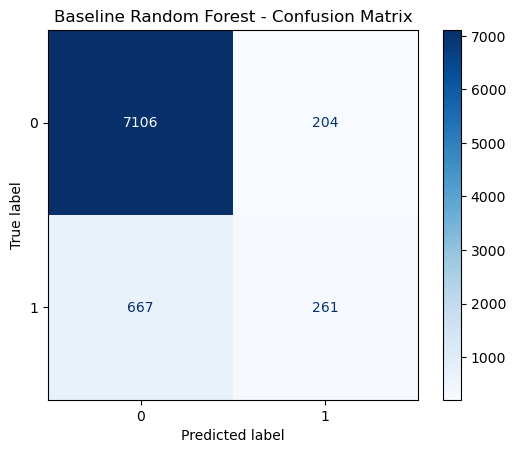

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Top GridSearchCV results (Random Forest) - 10-fold CV


,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,Mean CV Accuracy,Std Dev
29,200,10,2,2,log2,0.506199,0.033076
28,100,10,2,2,log2,0.505660,0.033617
31,200,10,5,2,log2,0.505392,0.032352
23,200,10,5,2,sqrt,0.504850,0.031885
19,200,10,5,1,sqrt,0.504045,0.033699
22,100,10,5,2,sqrt,0.503508,0.031706
30,100,10,5,2,log2,0.503237,0.030367
20,100,10,2,2,sqrt,0.503237,0.033134
21,200,10,2,2,sqrt,0.503235,0.030319
18,100,10,5,1,sqrt,0.501886,0.035794


In [14]:
# Base Random Forest
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)
ConfusionMatrixDisplay.from_estimator(rf_base, X_test, y_test, cmap="Blues")
plt.title("Baseline Random Forest - Confusion Matrix")
plt.show()

# 10-Fold CV accuracy (on the full selected dataset)
cv_scores = cross_val_score(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    X_preprocessed, y, cv=10, scoring='accuracy', n_jobs=-1
)
# Hyperparameter tuning (GridSearchCV)
# Keep grid small enough to run reasonably fast but expressive enough to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# We include class_weight to favour recall on the positive class as you wanted earlier
rf_clf = RandomForestClassifier(random_state=42, class_weight={0:1, 1:3}, n_jobs=-1)

grid_search = GridSearchCV(
    rf_clf,
    param_grid=param_grid,
    cv=10,
    scoring='recall',
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)

# 5) Summarize GridSearch results in a neat table
results_df = pd.DataFrame(grid_search.cv_results_)

# Select and rename relevant columns
results_summary = results_df[[
    'param_n_estimators',
    'param_max_depth',
    'param_min_samples_split',
    'param_min_samples_leaf',
    'param_max_features',
    'mean_test_score',
    'std_test_score'
]].rename(columns={
    'param_n_estimators': 'n_estimators',
    'param_max_depth': 'max_depth',
    'param_min_samples_split': 'min_samples_split',
    'param_min_samples_leaf': 'min_samples_leaf',
    'param_max_features': 'max_features',
    'mean_test_score': 'Mean CV Accuracy',
    'std_test_score': 'Std Dev'
})

results_summary = results_summary.sort_values(by='Mean CV Accuracy', ascending=False)
print("Top GridSearchCV results (Random Forest) - 10-fold CV")
display(results_summary.head(15))   # show top 15 combos

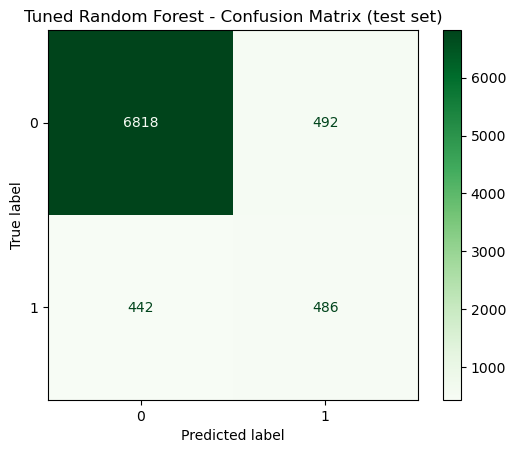

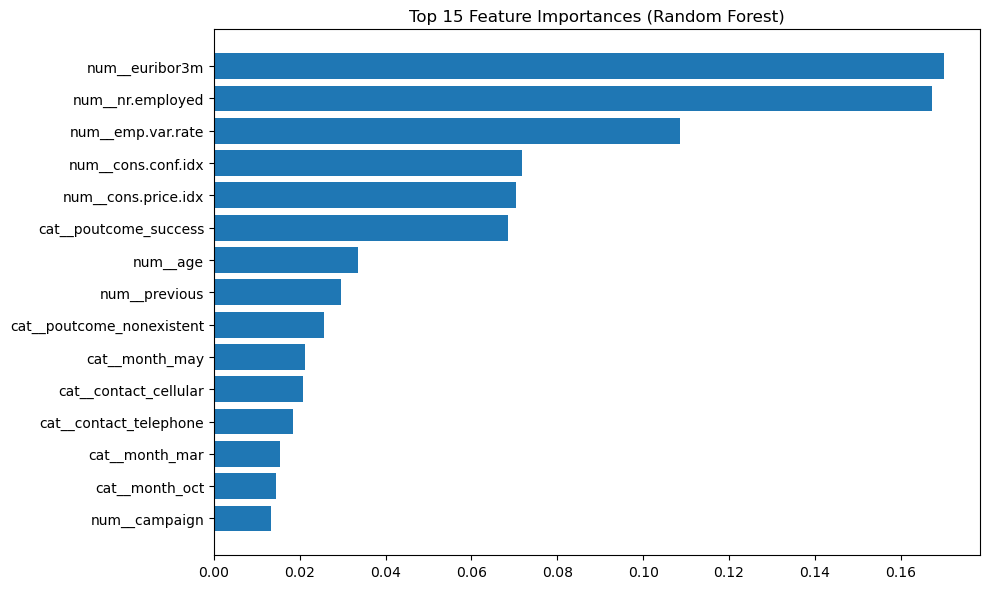

In [15]:
# Evaluate best estimator on the test set
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap="Greens")
plt.title("Tuned Random Forest - Confusion Matrix (test set)")
plt.show()

# Feature importances (from the best RF) - show top features
feature_names = preprocessor.get_feature_names_out()
X_preprocessed_df = pd.DataFrame(
    X_preprocessed.toarray() if hasattr(X_preprocessed, "toarray") else X_preprocessed,
    columns=feature_names
)

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_imp['feature'].head(15)[::-1], feat_imp['importance'].head(15)[::-1])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

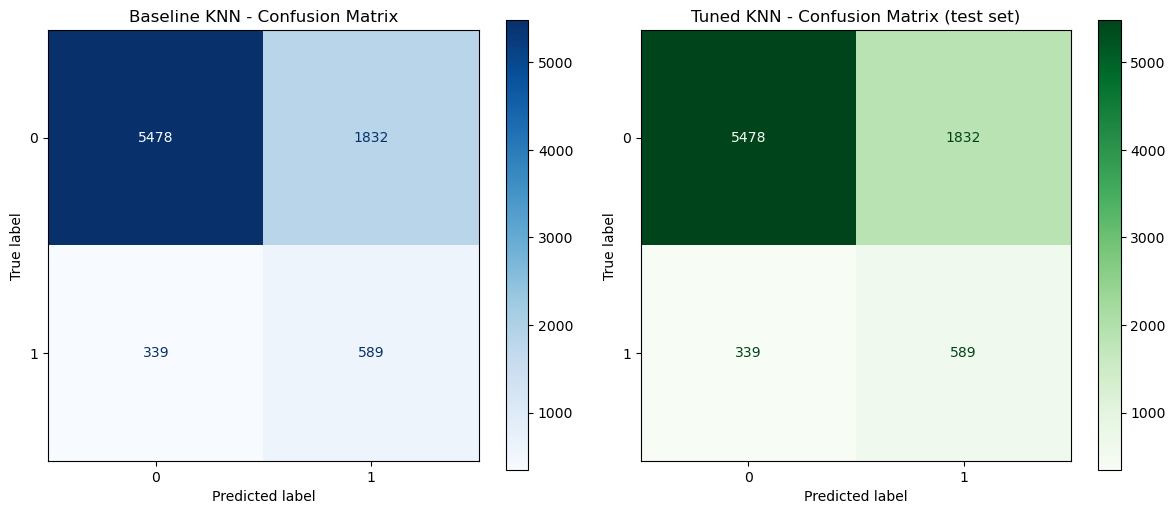

Top GridSearchCV results (KNN) - 10-fold CV


,n_neighbors,weights,metric,Mean CV Recall,Std Dev
4,5,uniform,euclidean,0.986217,0.004255
2,3,uniform,euclidean,0.985293,0.004800
5,5,distance,euclidean,0.985157,0.013807
7,7,distance,euclidean,0.985088,0.014445
9,9,distance,euclidean,0.984370,0.014787
6,7,uniform,euclidean,0.984233,0.004462
11,11,distance,euclidean,0.983481,0.015168
3,3,distance,euclidean,0.983344,0.014234
13,15,distance,euclidean,0.982934,0.015589
15,21,distance,euclidean,0.980300,0.016327


In [22]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

knn_base = KNeighborsClassifier()
knn_base.fit(X_train_balanced, y_train_balanced)
y_pred_base = knn_base.predict(X_test)

cv_scores = cross_val_score(
    KNeighborsClassifier(),
    X_preprocessed, y, cv=10, scoring=make_scorer(recall_score, pos_label=1), n_jobs=-1
)

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_clf = KNeighborsClassifier()

grid_search = GridSearchCV(
    knn_clf,
    param_grid=param_grid,
    cv=10,
    scoring=make_scorer(recall_score, pos_label=1),
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train_balanced, y_train_balanced)
results_df = pd.DataFrame(grid_search.cv_results_)

results_summary = results_df[[
    'param_n_neighbors',
    'param_weights',
    'param_metric',
    'mean_test_score',
    'std_test_score'
]].rename(columns={
    'param_n_neighbors': 'n_neighbors',
    'param_weights': 'weights',
    'param_metric': 'metric',
    'mean_test_score': 'Mean CV Recall',
    'std_test_score': 'Std Dev'
})
results_summary = results_summary.sort_values(by='Mean CV Recall', ascending=False)

best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test)

# Show booth plots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(knn_base, X_test, y_test, cmap="Blues", ax=axes[0])
axes[0].set_title("Baseline KNN - Confusion Matrix")

ConfusionMatrixDisplay.from_estimator(best_knn, X_test, y_test, cmap="Greens", ax=axes[1])
axes[1].set_title("Tuned KNN - Confusion Matrix (test set)")

plt.tight_layout()
plt.show()

print("Top GridSearchCV results (KNN) - 10-fold CV") 
display(results_summary.head(15))